# This notebook contains my code from Will Tipton's "Solving Poker" video series

In [1]:
import pokereval
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pe = pokereval.PokerEval()

In [3]:
# Can access documentation in iPython with ?
pokereval.PokerEval?

In [4]:
# Define some useful constants
numCards = 52
numRanks = 13
numSuits = 4
numHands = 1326 # nchoosek(52,2)
numVillainHands = 1225 # nchoosek(50,2)

# Make some lists

suits = ['h', 'd', 'c', 's']
ranks = ['A', 'K', 'Q','J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']
cards = ['2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', 'Th', 'Jh', 'Qh', 'Kh', 'Ah', 
         '2d', '3d', '4d', '5d', '6d', '7d', '8d', '9d', 'Td', 'Jd', 'Qd', 'Kd', 'Ad',
         '2c', '3c', '4c', '5c', '6c', '7c', '8c', '9c', 'Tc', 'Jc', 'Qc', 'Kc', 'Ac', 
         '2s', '3s', '4s', '5s', '6s', '7s', '8s', '9s', 'Ts', 'Js', 'Qs', 'Ks', 'As']

In [5]:
# We can describe hands or the board as lists of strings, where '__' represents an unknown card
handAsStrings = ['Ah', 'Jd']
boardAsStrings = ['8d', '6s', '3h', 'Kd', '__']

In [6]:
# We can also give each card a number and describe hands or boards as lists of numbers
# Convention: always work with the numerical representation of hands and boards
#    Convert to strings at the last minute whenever it's necessary, and we'll indicate the stringness
#    in the variable name.  Whenever we want to manually input hand or board, we'll need to convert
# Notice that cards run from 0 to 51, while empty card gets 255
hand = pe.string2card(handAsStrings)
board = pe.string2card(boardAsStrings)

In [7]:
#  Let's write our own function!  It's good practice to document the inputs and outputs of functions.
#  It will be useful to have a function that takes as input two lists of cards, and tells us
#  if the two lists overlap at all.  To do this, look at every pair of cards and check if equal
#  Input:
#      cards1, cards2 - lists of cards represented as numbers
#  Output:
#    True if the lists conflict and False otherwise
#  NB: Indentation matters.
#  Note:  We don't return true if we find a match for the empty card (255).

def conflicts(cards1, cards2):
    for i in cards1:
        for j in cards2:
            if i == j and i < numCards:
                return True
    return False

In [8]:
#  Note that the conflicts function is _globally_ accessible
conflicts(board, pe.string2card(['2h', '3h']))

True

In [9]:
villainHand = pe.string2card(['As', '4s'])
peresult = pe.poker_eval(game='holdem', pockets=[ hand, villainHand], board = board)

In [10]:
peresult['eval'][0]['winhi']

41

In [11]:
# Compute an equity using pe.poker_eval and make a function to take care of the details
# Inputs:
#     hands and villainHand - lists of cards in numerical format describing two hands
#     board - list of cards describing the board
# Output: all-in equity of hand vs villainHand on board
#         -1 if any of hand, villainHand, and board conflict

def getEquityVsHand(hand, villainHand, board):
    if conflicts(hand,villainHand) or conflicts(hand,board) or conflicts(board,villainHand):
        return -1
    peresult = pe.poker_eval(game='holdem', pockets=[hand, villainHand], board = board)
    numWins = peresult['eval'][0]['winhi']
    numTies = peresult['eval'][0]['tiehi']
    numRunouts = peresult['info'][0]
    return (numWins + numTies/2.0) / numRunouts

In [12]:
hand1 = pe.string2card(['Ah', 'Jd'])
hand2 = pe.string2card(['4c', '3s'])
getEquityVsHand(hand1, hand2, board)

0.13636363636363635

In [13]:
# To avoid expensive equity calculations, we will pre-compute all equities for any
# board we are interested in.
# Essentially, we'll make a table that contains all hand-vs-hand matchups, and we'll computer
# the equity of every matchup once.  And then if we need it in the future, we can just look it up.

# EquityArray class organizes hand vs hand equities for a board
class EquityArray:
    # Constructor
    # Input:
    #    b - list of numbers representing a board
    def __init__(self, b): 
        self.board = b
        self.eArray = numpy.zeros ((numCards,numCards,numCards,numCards))
        if os.path.isfile(self.getFilename()):
            self.eArray = numpy.load(self.getFilename())
        else:
            self.makeArray()
                
    def makeArray(self): #can you cut down on hand combos here through only considering isomorphic combos?
        for i in range(numCards):
            for j in range (numCards):
                for a in range(numCards):
                    for b in range(numCards):
                        hand = [i, j]
                        villainHand = [a, b]
                        self.eArray[i][j][a][b] = getEquityVsHand(hand, villainHand, self.board)
        numpy.save(self.getFilename(), self.eArray)
                                
    # Output: filename built from self.board
    # For example, if pe.card2string(self.board) == ['Ah', 'Jd', '2c', '__','__']
    # then return 'AhJd2c.ea.npy'.
    def getFilename(self):
        boardStr = ''
        boardAsStrings = pe.card2string(self.board)
        for i in boardAsStrings:
            if i != '__':
                boardStr = boardStr + i
            if boardStr == '': #this is the case when we have the preflop board
                boardStr = 'preflop'
        boardStr = boardStr + '.ea.npy'
        return boardStr

In [14]:
pe.card2string(board)

['8d', '6s', '3h', 'Kd', '__']

In [15]:
myEArray = EquityArray(board)

In [16]:
myEArray.getFilename()

'8d6s3hKd.ea.npy'

In [17]:
# All the different possible flops

for i in range(numCards):
    for j in range (numCards):
        for a in range(numCards):
            print(pe.card2string([i,j,a]))

['2h', '2h', '2h']
['2h', '2h', '3h']
['2h', '2h', '4h']
['2h', '2h', '5h']
['2h', '2h', '6h']
['2h', '2h', '7h']
['2h', '2h', '8h']
['2h', '2h', '9h']
['2h', '2h', 'Th']
['2h', '2h', 'Jh']
['2h', '2h', 'Qh']
['2h', '2h', 'Kh']
['2h', '2h', 'Ah']
['2h', '2h', '2d']
['2h', '2h', '3d']
['2h', '2h', '4d']
['2h', '2h', '5d']
['2h', '2h', '6d']
['2h', '2h', '7d']
['2h', '2h', '8d']
['2h', '2h', '9d']
['2h', '2h', 'Td']
['2h', '2h', 'Jd']
['2h', '2h', 'Qd']
['2h', '2h', 'Kd']
['2h', '2h', 'Ad']
['2h', '2h', '2c']
['2h', '2h', '3c']
['2h', '2h', '4c']
['2h', '2h', '5c']
['2h', '2h', '6c']
['2h', '2h', '7c']
['2h', '2h', '8c']
['2h', '2h', '9c']
['2h', '2h', 'Tc']
['2h', '2h', 'Jc']
['2h', '2h', 'Qc']
['2h', '2h', 'Kc']
['2h', '2h', 'Ac']
['2h', '2h', '2s']
['2h', '2h', '3s']
['2h', '2h', '4s']
['2h', '2h', '5s']
['2h', '2h', '6s']
['2h', '2h', '7s']
['2h', '2h', '8s']
['2h', '2h', '9s']
['2h', '2h', 'Ts']
['2h', '2h', 'Js']
['2h', '2h', 'Qs']
['2h', '2h', 'Ks']
['2h', '2h', 'As']
['2h', '3h',

In [18]:
def getEquityvsHandFast(hand, villainHand, ea):
    return ea.eArray()

In [19]:
def getEquityVsHandFast(hand, villainHand, ea):
    return ea.eArray[hand[0]][hand[1]][villainHand[0]][villainHand[1]]

In [20]:
# getEquityVsHand(hand, villainHand, board)
# getEquityVsHandFast(hand, villainHand, myEArray)

In [21]:
# Inputs:
#  handArray - numpy array of the same sort that is internal to the Range class
#  cardslist - list of cards in numerical format
# Outputs: N/A
# Side-effect: modifies handArray to set the frequency of all hands that conflict with cards in cardslist to 0

def zeroHandsWithConflicts(handArray, cardslist):
    for c in cardslist:
        if c < numCards:
            handArray[c,:] = 0
            handArray[:,c] = 0

In [22]:
import scipy.misc

In [69]:
# Range class describes a poker hand range
# The data:
# a numpy array of sides numCards by numCards, r, of numbers between 0 and 1, each of which describes the fraction
# of a particular hand in the range
# Note: there is some redundancy in our representation.  For example, (3h, 2h) - (2h, 3h)
# We are only going to access elements of r, r[i][j] such that j > 1

class Range:
    def __init__(self, initFrac = None):
        self.r = numpy.zeros((numCards, numCards))
        if initFrac != None:
            self.setAllFracs(initFrac)
    
    # Input: a hand represented by a list of two numbers
    # Output: the fraction of the hand contained in the range
    # Side-effects: N/A
    def getFrac(self, hand):
        card1, card2 = hand
        if card1 > card2:
            card1,card2 = card2,card1
        return self.r[card1][card2]
    
    # Input: N/A
    # Output: total number of hand combinations contained in the range
    # Side-effects: N/A
    def getNumHands(self):
        return sum(self.r)
    
    # Input: cardslist - list in numerical format
    # Output: the number of hand combos in the range that do not conflict with cardslist
    # Side-effects: N/A
    def getNumHandsWithoutConflicts(self, cardslist):
        temp = numpy.copy(self.r)
        zeroHandsWithConflicts(temp, cardslist)
        return sum(temp)
    
    # Input: cardslist - list in numerical format
    # Output: N/A
    # Side-effects: removes hands from range that conflict with cards in cardslist
    def removeHandsWithConflicts(self, cardslist):
        zeroHandsWithConflicts(self.r, cardslist)
    
    # Inputs:
    #   hand - list of numbers describing a hand
    #   f - fraction
    # Output: N/A
    # Side-effects: sets the fraction of hand in the range to f
    def setFrac(self, hand, f):
        card1, card2 = hand
        if card1 > card2:
            card1,card2 = card2,card1
        self.r[card1][card2] = f
    
    # Input: num - a fraction
    # Output: N/A
    # Side-effects: set the fraction of all hand combos to num
    def setAllFracs(self, num):
            for i in range(numCards):
                for j in range(i+1, numCards):
                    self.r[i][j] = num
    
    # Input: num - a fraction
    # Output: N/A
    # Side-effect: scale the fraction of every hand combo by num
    # NB: We haven't always performed great input validation.  For example, here it is up to
    #   the user of the function to ensure that the scaling number does not change any of the fractions
    #   to be less than 0 or greater than 1.
    def scaleFracs(self, num):
        self.r = self.r * num        

    # Input:
    #   - rangeString - string containing comma-separated terms of the form XX, XY, XYs, XYo, XaYb
    #   - value - a fraction
    # Output: N/A
    # Side-effects: set hand combos specified by the range string to values
    
    def setRangeString(self, rangeString, value):
        handStrs = rangeString.replace(' ','').split(',')
        for hand in handStrs:
            if len(hand) == 2:
                rank1 = hand[0]
                rank2 = hand[1]
                for i in suits:
                    for j in suits:
                        if rank1 == rank2 and i == j : # avoid stuff like 2c2c
                            continue
                        self.setFrac(pe.string2card([rank1+i, rank2+j]), value)
            elif len(hand) == 3:
                rank1 = hand[0]
                rank2 = hand[1]
                if rank1 == rank2:
                    print("ERROR! Cannot have suited pocket pair")
                if hand[2] == 's': # suited hands
                    for s in suits:
                        self.setFrac(pe.string2card([rank1+s, rank2+s]), value)
                else: # unsuited hands
                    for i in range(numSuits):
                        for j in range(i+1, numSuits):
                            self.setFrac(pe.string2card([rank1+suits[i], rank2+suits[j]]), value)
            elif len(hand) == 4:
                card1 = hand[0:2]
                card2 = hand[2:4]
                self.setFrac(pe.string2card([card2, card2]), value)
            else:
                print("ERROR! Hand input needs to be 2 to 4 characters")
    
    # Input: 
    #  - rank1 - a string specifying a rank ('2', '3', 'T', 'A')
    #  - rank2 - similar
    #  - suited - a boolean (True, False) indicating suitedness
    # Output: fraction of specified ambiguous hand contained in the rank
    # Side-effects: N/A
    #
    # Ambiguous hands are, e.g., AKo (12 combos)
    #                            AKs (4 combos)
    #                            33 (6 combos)
    # So for example, if we call getAmbigFrac('A', 'K', True), we're interested
    # in AKs, and if the range contains 100% of AKhh and AKss, but none of AKcc
    # or AKdd, the result should be 0.5 (not 2).
    # Note: if we're interested in pocket pairs then rank1 == rank2 and suited == False
    def getAmbigFrac(self, rank1, rank2, suited):
        nHand = 0.0
        nFrac = 0.0
        
        # look at every specific hand combo corresponding to rank1, rank 2 and suited
        for i in suits:
            for j in suits:
                card1 = rank1 + i
                card2 = rank2 + j
                if (suited and i != j) or (not suited and i == j):
                    continue
                if (card1 == card2):
                    continue
                nHand += 1 # short for nHand = nHand + 1
                nFrac += self.getFrac(pe.string2card([card1,card2]))
        return nFrac / nHand
    
    def _repr_svg_(self): # iPython special function - represent as scalable vector graphic
        result = '<svg xmlns="http://www.w3.org/2000/svg" version="1.1" width="260" height="260">'
        for i in range(numRanks):
            for j in range(numRanks):
                frac = self.getAmbigFrac(ranks[i], ranks[j], i > j)
                hexcolor = '#%02x%02x%02x' % (255*(1-frac), 255, 255*(1-frac))
                result += '<rect x="' + str(i*20) + '" y="' + str(j*20) + '" width="20" height="20" fill="' + hexcolor+'"></rect>'
                result += '<text x=' + str(i*20)+' y='+str((j+1)*20) + ' font-size=12>' + ranks[i]\
                          + ranks[j] + '</text>'
        result += '</svg>'    
        return result
    
    # Input:
    #   villainRange - Range object
    #   board - list of 5 numbers describing a board
    # Output: list of tuples of the form (hand, equity)
    #                       where a hand is a list of integers and equity is
    #                       equity vs villainRange on board.  This output list
    #                       will be sorted by equity (highest first).
    # Side-effects: N/A
    def getHandsSortedAndEquities(self, villainRange, board):
        ea = EquityArray(board)
        result = []
        for i in range(numCards):
            for j in range(i+1, numCards):
                hand = [i,j]
                if not conflicts(board,hand):
                    result.append((hand, getEquityVsRange(hand, villainRange, ea)))
        result.sort(key = lambda x: x[1], reverse = True)
        return result
                
    
    # Input:
    #  fraction - a number describing fraction of all hands
    #  board - a list of numbers representing a board
    #  Output: N/A
    #  Side-effects: set fraction of (approx.) the top fraction of hands (as ranked by equity vs ATC) on board to 1, and the rest to 0
    def setToTop(self, fraction, board):
        rangeAllHands = Range()
        rangeAllHands.setAllFracs(1.0) # ATC range
        handsSorted = self.getHandsSortedAndEquities(rangeAllHands, board)
        
        numCardsLeft = numCards
        for c in board:
            if c < numCards:
                numCardsLeft -= 1
        self.setAllFracs(0)
        for i in range(int(fraction * scipy.misc.comb(numCardsLeft, 2))):
            self.setFrac(handsSorted[i][0],1.0)

In [24]:
# Input:
#   hand - list of numbers
#   r - Range object
#   ea - Equity Array object

def getEquityVsRange(hand, r, ea):
    herocard1, herocard2 = hand
    eqs = ea.eArray[herocard1, herocard2, :, :] # Equity of all hands vs hero hands.  ea is an Equity Array of numCards x numCards x numCards x numCards.
    # r.r                 # numCards x numCards
    villRange = np.copy(r.r)
    zeroHandsWithConflicts(villRange, hand + ea.board)
    return sum(np.multiply(eqs, villRange)) / sum(villRange) # np.multiply is pairwise multiplication, not matrix

In [25]:
print(pe.card2string(hand))
print(pe.card2string(board))
vill = Range()
vill.setAllFracs(1.0)
getEquityVsRange(hand, vill, EquityArray(board))

['Ah', 'Jd']
['8d', '6s', '3h', 'Kd', '__']


0.45252525252525255

In [26]:
frac = 0.5
print('#%02x%02x%02x' % (255*(1-frac), 255, 255*(1-frac))) # %02 means take a number and represent it as a hexadecimal

#7fff7f


In [27]:
bob = Range()
bob.setRangeString("AK,44,Q4",1.0)
display(bob)

In [28]:
hero = Range()
hero.setAllFracs(1.0)
hero.setFrac(pe.string2card(['Ah', 'Jh']),0.5)
hero.setFrac(pe.string2card(['Ac', 'Jc']),0.5)
hero.setFrac(pe.string2card(['As', 'Js']),0.5)
hero.setToTop(0.20,board)
display(hero)

In [29]:
# Plot equity distributions of r1 vs r2 on board
def plotEqDistn(r1, r2, board):
    xs = []
    ys = []
    handCount = 0.0
    for hand in r1.getHandsSortedAndEquities(r2, board):
        # plot hand at (handCount, equity) and (handCount + r1.getFrac(hand[0]), equity)
        xs.append(handCount)
        handCount += r1.getFrac(hand[0])
        xs.append(handCount)
        ys.append(hand[1])
        ys.append(hand[1])
    plot (xs, ys)

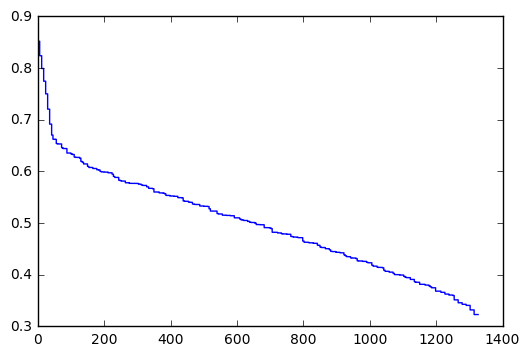

In [30]:
pfBoard = pe.string2card(['__', '__', '__', '__', '__'])
ATC = Range(1.0)
plotEqDistn(ATC, ATC, pfBoard)

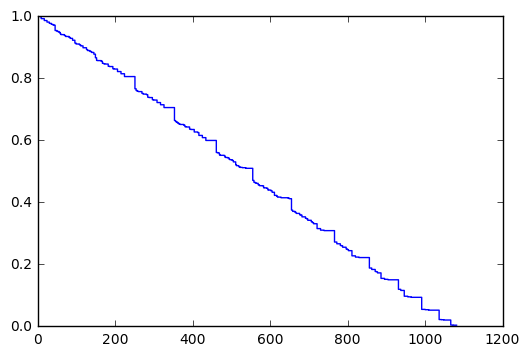

In [31]:
board2 = pe.string2card(['8d', '6s', '3h', 'Kd', 'Jd'])
range1 = Range(1.0)
range2 = Range(1.0)
plotEqDistn(range1, range2, board2)

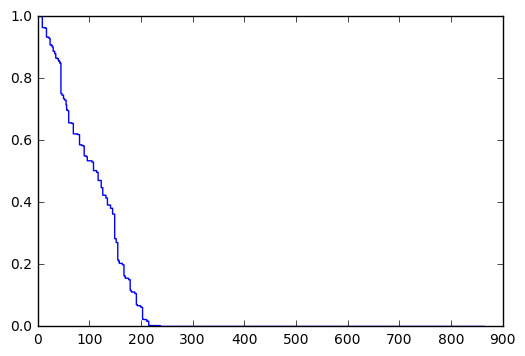

In [32]:
range1.setToTop(0.2, board2)
range2.setToTop(0.8, board2)
plotEqDistn(range2, range1, board2)

In [33]:
# Input: 
#  r1 and r2 - Ranges
#  n - positive integer
# Output: N/A
# Side-effect:
#   Modifies r1 to incorporate some amount of r2.  In particular, the fraction of every hand in r1 at
#   the end of the function will be (old amount) * (fraction) + (new amount) * (1-fraction)
#   where fraction becomes closer to 1 the higher n is.
def updateRange(r1, r2, n):
    fraction = 1 - (1 / (n + 2.0)) # Better if the fraction here is never exactly 0 or exactly 1
    for i in range(numCards):
        for j in range(i+1, numCards):
            hand = [i, j]
            r1.setFrac(hand, (r1.getFrac(hand)) * (fraction) + (r2.getFrac(hand)) * (1-fraction))

In [34]:
# Solving the shove/fold:
# SB can either shove or fold at his first decision
# SB's strategy is defined by his jamming range, and the BB's by his calling range

# Fictitious play

# Input: N/A
# Outputs: N/A
# Side-effects: display SB shoving range and BB calling range
def doShoveFoldGame():
    nIter = 200 # Number of iterations
    S = 10 # stack size in BBs
    ea = EquityArray(pe.string2card(['__','__','__','__','__']))
    
    # guess some initial ranges
    sbJamRange = Range()
    sbJamRange.setAllFracs(0.5)
    bbCallRange = Range()
    bbCallRange.setAllFracs(0.5)
    
    for n in range(nIter):
        # solve for the SB max expl strat
        bestSBJamRange = Range()
        for i in range(numCards):
            for j in range(i+1, numCards):
                hand = [i,j]
                bb_call_freq = bbCallRange.getNumHandsWithoutConflicts(hand) / numVillainHands
                equity = getEquityVsRange(hand, bbCallRange, ea)
                evJam = (1 - bb_call_freq) * (S+1) + (bb_call_freq) * equity * 2*S
                evFold = S - 0.5
                if (evJam > evFold):
                    bestSBJamRange.setFrac(hand, 1)
                else:
                    bestSBJamRange.setFrac(hand, 0)
        
        # update the SB strategy
        updateRange(sbJamRange, bestSBJamRange, n)
        
        # solve for BB max expl strat
        bestBBCallRange = Range()
        for i in range(numCards):
            for j in range(i+1, numCards):
                hand = [i, j]
                equity = getEquityVsRange(hand, sbJamRange, ea)
                evCall = 2 * S * equity
                evFold = S - 1
                if (evCall > evFold):
                    bestBBCallRange.setFrac(hand, 1)
                else:
                    bestBBCallRange.setFrac(hand, 0)
        # update BB strat
        updateRange(bbCallRange, bestBBCallRange, n)    
        
    display(sbJamRange)
    display(bbCallRange)

In [35]:
doShoveFoldGame()

In [36]:
# Future work:
# Decision trees
# Strategies for playing decision trees
# Maximally exploitative strategies
# Use fictitious play to find equilibriums

In [37]:
# A decision point will hold:
# player: a string describing whose decision point it is
#         one of: "SB", "BB", "Nature", or "Leaf"
# initial_sb_cip: SB chip in pot before any decision is made at this point
# initial_bb_cip: similar
# eArray: an EquitiesArray describing the current board
# parentAction: a string describing the action that got us to this point
#               one of: "bet", "fold", "check", "call", or board cards
# newCardFreq:  only used if parentAction was new cards being dealt, and we
#               don't want all new cards to have equal probability of falling

class DecPt:
    def __init__(self, player, initial_sb_cip, initial_bb_cip, eArray, parentAction, newCardFreq = 1.0):
        self.player = player
        self.initial_sb_cip = initial_sb_cip
        self.initial_bb_cip = initial_bb_cip
        self.eArray = eArray
        self.parentAction = parentAction
        self.newCardFreq = newCardFreq

# Input: player: string that is either "SB" or "BB"
# Output: chips in pot of player at beginning of decision point
    def getPlayerCIP(self, player):
        if (player == "SB"):
            return sb_initial_cip
        elif (player == "BB"):
            return bb_initial_cip
        else:
            print "ERROR: DecPt.getPlayerCIP given player: " + player

In [38]:
# A simple approach to a tree structure:
# Put all our decision points in a list (this implicitly numbers them):
#    decPts
# Then, we need to keep track of parent and child relationship -- use a couple other arrays to do that
#   parents: the i^th element of this array contain the number of the point which is the i^th point's parent
#   children: the i^th entry in this list contain a list of the numbers of points which are the i^th 
#             point's children.  And if we want to know point i's children, we can find a list of them in
#             children[i]
# Example:
#             0       1     2        3         4
# decPts: (pointA, pointB, pointC, pointD, pointE)
# children: [ [], [], [], [1, 2], [0, 3]]
# parents: [4, 3, 3, 4, None]
# When we make a new tree, we'll just give it effective stack S, and a first decision point (root)
# Later, we will add new decision points
class Tree:
    def __init__(self, S, root):
        self.effStack = S
        self.decPts = []
        self.children = []
        self.parents = []
        self.addDecPt(root, None)
    
    # Inputs: N/A
    # Outputs: number of decision points in the tree
    # Side-effects: N/A
    def getNumPoints(self):
        return len(self.decPts)
    
    # Inputs: N/A
    # Outputs: Effective stack at the beginning of the decision tree
    #          (corresponds to beginning of the hand, i.e. the case when players' CIP is 0)
    # Side-effects: N/A
    def getEffStack():
        return self.effStack
    
    # Adds a new decision point to the tree
    # Inputs:
    #     point: the new point (not previously in the tree)
    #     parent: a decision point already in the tree
    # Outputs: N/A
    # Side-effects: Adds a new decision point to the tree
    def addDecPt(self, point, parent):
        self.decPts.append(point)
        self.children.append([])
        if (parent == None): # this should only be true for the root node
            self.parents.append(None) # Is this line needed?
        else:
            parentIndex = self.decPts.index(parent)
            self.children[parentIndex].append(self.getNumPoints() - 1)
            self.parents.append(parentIndex)
    
    # Inputs: N/A
    # Outputs: returns a PNG file displaying the tree
    # Side-effects: N/A
    def _repr_png_(self):
        g = pydot.Dot(graph_type="digraph")
        for i in range(self.getNumPoints()):
            node_label = str(i) + ': ' + self.decPts[i].player \
                         + ' (' + str(self.decPts[i].initial_sb_cip) + ',' \
                         + str(self.decPts[i].initial_bb_cip) + ')'
            g.add_node(pydot.Node('node%d'%i, label=node_label))
        for i in range(self.getNumPoints()):
            for j in self.children[i]:
                g.add_edge(pydot.Edge('node%d'%i, 'node%d'%j, label=self.decPts[j].parentAction))
        return g.create(g.prog, 'png')

In [39]:
# pydot/graphviz
# 1. install graphviz (graphviz.org)
# 2. install pydot2 (using pip)
# 3. change the Windows PATH variable
# 4. restart IPython

In [40]:
import pydot
from IPython.core.display import Image

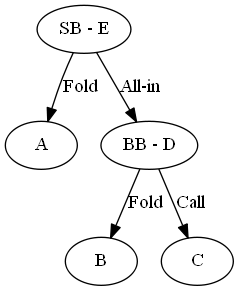

In [41]:
g = pydot.Dot(graph_type="digraph")
g.add_node(pydot.Node('pointA', label='A'))
g.add_node(pydot.Node('pointB', label='B'))
g.add_node(pydot.Node('pointC', label='C'))
g.add_node(pydot.Node('pointD', label='BB - D'))
g.add_node(pydot.Node('pointE', label='SB - E'))

g.add_edge(pydot.Edge('pointE','pointA',label="Fold"))
g.add_edge(pydot.Edge('pointE','pointD',label="All-in"))
g.add_edge(pydot.Edge('pointD','pointB',label="Fold"))
g.add_edge(pydot.Edge('pointD','pointC',label="Call"))

Image(g.create(g.prog, 'png'))

In [42]:
S = 20
preflopEArray = EquityArray(pe.string2card(['__', '__', '__', '__', '__']))
point0 = DecPt("SB", 0.5, 1.0, preflopEArray, "")
point1 = DecPt("Leaf", 0.5, 1.0, preflopEArray, "fold")
point2 = DecPt("BB", 2.0, 1.0, preflopEArray, "bet")
point3 = DecPt("Leaf", 2.0, 1.0, preflopEArray, "fold")
point4 = DecPt("SB", 2.0, 20.0, preflopEArray, "bet")
point5 = DecPt("Leaf", 2.0, 20.0, preflopEArray, "fold")
point6 = DecPt("Leaf", 20.0, 20.0, preflopEArray, "call")

minrShoveTree = Tree(S, point0)
minrShoveTree.addDecPt(point1, point0)
minrShoveTree.addDecPt(point2, point0)
minrShoveTree.addDecPt(point3, point2)
minrShoveTree.addDecPt(point4, point2)
minrShoveTree.addDecPt(point5, point4)
minrShoveTree.addDecPt(point6, point4)

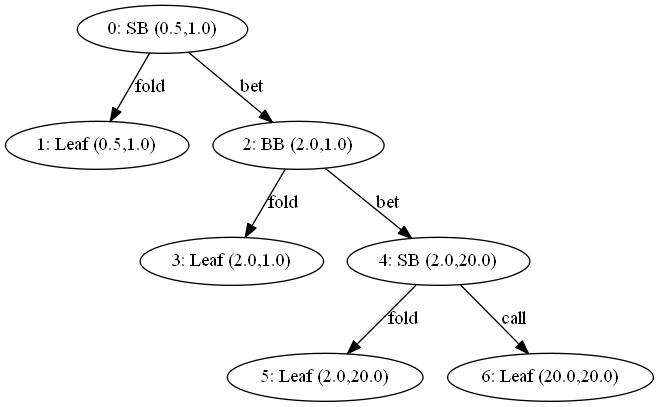

In [43]:
minrShoveTree

In [44]:
# Suppose SB checks back AKQr flop in a singly raised pot.  FD comes on the turn where BB is somewhat
#   polar.  Model with the PvBC decision tree and two possible river cards.
S = 20

turnEArray = EquityArray(pe.string2card(['Ah', 'Kd', 'Qs', '2d', '__']))
river1EArray = EquityArray(pe.string2card(['Ah', 'Kd', 'Qs', '2d', '6d']))
river2EArray = EquityArray(pe.string2card(['Ah', 'Kd', 'Qs', '2d', '6s']))

point0 = DecPt('BB', 2.0, 2.0, turnEArray, "")
point1 = DecPt('SB', 2.0, 2.0, turnEArray, "check")
point2 = DecPt('Nature', 2.0, 2.0, turnEArray, "check")
point3 = DecPt('BB', 2.0, 2.0, river1EArray, "AhKdQs2d6d")

point4 = DecPt('BB', 2.0, 2.0, turnEArray, "AhKdQs2d6s")
point5 = DecPt('SB', 2.0, 2.0, turnEArray, "check")
point6 = DecPt('SB', 2.0, 2.0, turnEArray, "check")

point7 = DecPt('Leaf', 2.0, 2.0, turnEArray, "check")
point8 = DecPt('SB', 2.0, 6.0, turnEArray, "bet")
point9 = DecPt('Leaf', 2.0, 6.0, turnEArray, "fold")

point10 = DecPt('Leaf', 6.0, 6.0, river1EArray, "call")
point11 = DecPt('Leaf', 2.0, 2.0, river2EArray, "check")
point12 = DecPt('SB', 2.0, 6.0, river2EArray, "bet")

point13 = DecPt('Leaf', 2.0, 6.0, river2EArray, "fold")
point14 = DecPt('Leaf', 6.0, 6.0, river2EArray, "call")
point15 = DecPt('SB', 6.0, 6.0, turnEArray, "bet")

point16 = DecPt('Leaf', 2.0, 6.0, turnEArray, "fold")
point17 = DecPt('Nature', 6.0, 6.0, turnEArray, "call")
point18 = DecPt('BB', 6.0, 6.0, river1EArray, "AhKdQs2d6d")

point19 = DecPt('SB', 6.0, 6.0, river1EArray, "check")
point20 = DecPt('Leaf', 6.0, 6.0, river1EArray, "check")
point21 = DecPt('SB', 6.0, 18.0, river1EArray, "bet")

point22 = DecPt('Leaf', 6.0, 18.0, river1EArray, "fold")
point23 = DecPt('Leaf', 18.0, 18.0, river1EArray, "call")
point24 = DecPt('BB', 6.0, 6.0, river1EArray, "AhKdQs2d6s")

point25 = DecPt('SB', 6.0, 6.0, river2EArray, "check")
point26 = DecPt('Leaf', 6.0, 6.0, river2EArray, "check")
point27 = DecPt('SB', 6.0, 18.0, river2EArray, "bet")
point28 = DecPt('Leaf', 6.0, 18.0, river2EArray, "fold")
point29 = DecPt('Leaf', 18.0, 18.0, river2EArray, "call")

T = Tree(S, point0)
T.addDecPt(point1, point0)
T.addDecPt(point2, point1)
T.addDecPt(point3, point2)
T.addDecPt(point4, point2)
T.addDecPt(point5, point3)
T.addDecPt(point6, point4)
T.addDecPt(point7, point5)
T.addDecPt(point8, point3)
T.addDecPt(point9, point8)
T.addDecPt(point10, point8)
T.addDecPt(point11, point6)
T.addDecPt(point12, point4)
T.addDecPt(point13, point12)
T.addDecPt(point14, point12)
T.addDecPt(point15, point0)
T.addDecPt(point16, point15)
T.addDecPt(point17, point15)
T.addDecPt(point18, point17)
T.addDecPt(point19, point18)
T.addDecPt(point20, point19)
T.addDecPt(point21, point18)
T.addDecPt(point22, point21)
T.addDecPt(point23, point21)
T.addDecPt(point24, point17)
T.addDecPt(point25, point24)
T.addDecPt(point26, point25)
T.addDecPt(point27, point24)
T.addDecPt(point28, point27)
T.addDecPt(point29, point27)

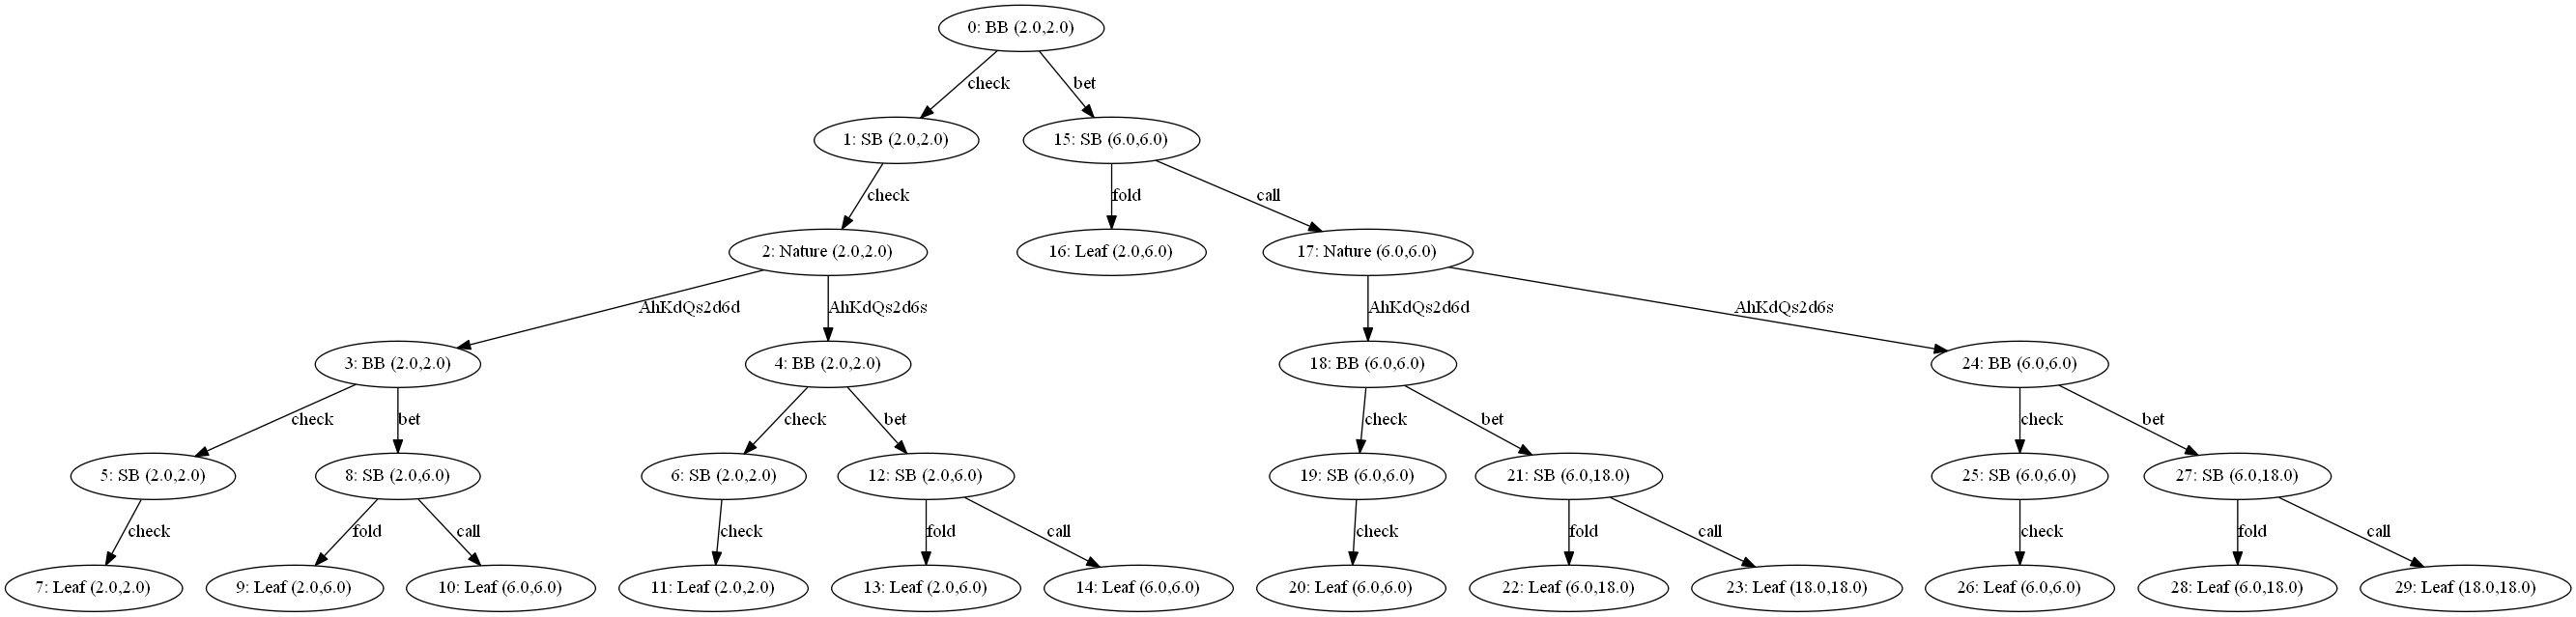

In [45]:
T

In [75]:
# StrategyPair
# Strategy: a range for every action a player can take
# Strategy Pair is a pair of strategies -- one for each player
# So basically, a strategy pair will contain a range for every player action in the game.  Also, since
#    there's an action for every decision point in the game (the point's parent action) (except the root)
#    we can essentially keep track of all the range by associating one range with each decision point.
#    (i.e. we'll number the ranges the same way we number decision points)
# So our StrategyPair class will:
#   - hold a tree, called tree, and keep track of the tree's size
#   - hold starting ranges for both players
#   - hold a list of ranges, called ranges, such that range[i] is the range of hands that takes the
#     parent action of the tree, decPts[i]
#       - when we make a new strategy pair, we'll need to set these ranges intelligently
#   - find the range that either player holds at any decision points
#   - be able to display itself
#   - be able to update itself (given a max exploitative strategy and a mixing fraction)
#   - store the EVs of having any hand at any decision point for each player
#     - there were will be two 3-D arrays, one for each player, of dimensions
#            num-decision-points by numCards by numCards
#         the first of those dimensions specifies a decision point, and the last two specify hole cards
#         and the arrays hold the EVs of having that hand at that decision point


# Come up with a guess for starting ranges that is strategically reasonable?

class StrategyPair:
    def __init__(self, tree, sbStartingRange = None, bbStartingRange = None):
        self.tree = tree
        self.size = self.tree.getNumPoints()
        self.ranges = [Range() for i in range(self.size)]
        self.evs = dict()
        self.evs['SB'] = numpy.zeros((self.size, numCards, numCards))
        self.evs['BB'] = numpy.zeros((self.size, numCards, numCards))
        self.sbStartingRange = sbStartingRange
        if sbStartingRange == None:
            self.sbStartingRange = Range(1.0)
        self.bbStartingRange = bbStartingRange
        if bbStartingRange == None:
            self.bbStartingRange = Range(1.0)
        #  initialize the ranges
        self.initialize()
    
    # Inputs:
    #  player: "SB" or "BB"
    #  maxExplStrat: a dict that maps decision point numbers to ranges for all of player's decision pts
    #  n: a positive integer (the iteration number)
    def updateRanges(self, player, maxExplStrat, n):
        for i in range(self.size):
            if (self.tree.decPts[i].player == player):
                for j in self.tree.children[i]:
                    updateRange(self.ranges[j], maxExplStrat[j], n)
    
    # Inputs:
    #  player: "SB" or "BB"
    #  iDecPt: the number (index) of the decision point we're interested in
    # Outputs: the range the player holds at the beginning of play at the decision point
    # Side-effects: N/A
    
    def getMostRecentRangeOf(self, player, iDecPt):
        iCurrDecPt = iDecPt
        while (self.tree.decPts[self.tree.parents[iCurrDecPt]].player != player):
            iCurrDecPt = self.tree.parents[iCurrDecPt]
            if iCurrDecPt == 0:  # we made it to the root
                return self.getStartingRangeOf(player)
        return self.ranges[iCurrDectPt]
    
    # Inputs: player: "SB" or "BB"
    # Outputs: the starting range of player
    # Side-effects: N/A
    def getStartingRangeOf(player):
        if player == "SB":
            return self.sbStartingRange
        elif player == "BB":
            return self.bbStartingRange
        else:
            print "ERROR in StrategyPair.getStartingRangeOf: passed player: " + player
            return None
    
    # Inputs: n: a number
    # Outputs: the range associated with the parent action of a decision point n
    # Side-effects: N/A
    def getRange(self, n):
        return self.range[n]
    
    # Inputs: N/A
    # Outputs: N/A
    # Side-effects: display all the ranges and actions in our tree and our solution
    def dump(self):
        for i in range(1, self.size):
            parentActor = self.tree.decPts[self.tree.parents[i]].player
            action = self.tree.decPts[i].parentAction
            print str(i) + ": " + parentActor + " " + action
            if parentActor != "Nature":
                display(self.ranges[i])
                
    # Recursive approach to working on trees:
    # When we want to do something for every node in a tree, we can write a function f(),
    # does whatever we want for one node, and then calls itself on all the children of that node.
    # Then, to do the thing for all the nodes, we just call f() on the root node.
    
    
    # Inputs: N/A
    # Outputs: N/A
    # Side-effects: sets all the ranges in the strategy pair, assuming the players start out with
    #               their starting ranges and randomly (uniformly) select an action at each dec pt
    def initialize(self):
        self.initializeHelper(0, 1.0, 1.0)
    
    # Inputs:
    #    iCurrDecPt: index of the current decision point
    #    sbScale and bbScale: numbers between 0 and 1 -- the fracation of the starting ranges that the
    #                         players bring to this decision point
    # Outputs: N/A
    # Side-effects: Set the range corresponding to the current decision point, and call itself
    #               on all of the point's children (so as to do the right thing for them too)
    def initializeHelper(self, iCurrDecPt, sbScale, bbScale):
        children = self.tree.children[iCurrDecPt]
        numChildren = len(children)
        if self.tree.decPts[iCurrDecPt].player == 'SB':
            sbScale /= numChildren
            for iChild in children:
                self.ranges[iChild].r = self.sbStartingRange.r.copy()
                self.ranges[iChild].scaleFracs(sbScale)
                self.ranges[iChild].removeHandsWithConflicts(self.tree.decPts[iCurrDecPt].eArray.board)
        elif self.tree.decPts[iCurrDecPt].player == 'BB':
            bbScale /= numChildren
            for iChild in children:
                self.ranges[iChild].r = self.bbStartingRange.r.copy()
                self.ranges[iChild].scaleFracs(bbScale)
                self.ranges[iChild].removeHandsWithConflicts(self.tree.decPts[iCurrDecPt].eArray.board)
        for iChild in children:
            self.initializeHelper(iChild, sbScale, bbScale)

In [78]:
spair = StrategyPair(T)

In [79]:
spair.dump()

1: BB check


2: SB check


3: Nature AhKdQs2d6d
4: Nature AhKdQs2d6s
5: BB check


6: BB check


7: SB check


8: BB bet


9: SB fold


10: SB call


11: SB check


12: BB bet


13: SB fold


14: SB call


15: BB bet


16: SB fold


17: SB call


18: Nature AhKdQs2d6d
19: BB check


20: SB check


21: BB bet


22: SB fold


23: SB call


24: Nature AhKdQs2d6s
25: BB check


26: SB check


27: BB bet


28: SB fold


29: SB call
